In [161]:
import torch

if torch.cuda.is_available():

    device = 'cuda'
else:

    device = 'cpu'
    
print(device)
print(torch.cuda.device_count())
print(torch.cuda.get_device_name())

cuda
1
Tesla K80


In [162]:
!pip install transformers

In [0]:
import torch
import pandas as pd
import numpy as np
from transformers import BertModel, BertTokenizer, BertForSequenceClassification

In [164]:
!pip install wget

In [0]:
import wget
import os

In [166]:
url = 'https://raw.githubusercontent.com/theneuralbeing/bert-finetuning-webinar/master/data.zip'
print('DownLoading Dataset')
if not os.path.exists('./data.zip'):
    wget.download(url,'./data.zip')
    !unzip data.zip
    print('Unzipped')

DownLoading Dataset


In [0]:
import pandas as pd

In [0]:
df = pd.read_csv('./data/train.csv',delimiter = ',',header = None, names = ['review','sentiment'])

In [169]:
print('Number of training sentence:{}\n'.format(df.shape[0]))   
print('Number of labels:{}\n'.format(df.shape[1]))

Number of training sentence:25001

Number of labels:2



In [170]:
df1 = pd.read_csv('./data/validation.csv',delimiter = ',',header = None, names = ['review','sentiment'])
print('Number of training sentence:{}\n'.format(df1.shape[0]))   
print('Number of labels:{}\n'.format(df1.shape[1]))

Number of training sentence:25001

Number of labels:2



In [171]:
df1.sample(10)

,review,sentiment
6189,Do NOT judge this production by the 2-hour ver...,1
21872,Watching Stranger Than Fiction director Marc F...,1
5726,It's been a long time since I last saw a movie...,0
12258,"Please humour me if you will, for a minute whi...",0
7069,This has to be the worst movie i've seen this ...,0
7651,"Now this is one of Big's Best, Jack Hulbert's ...",1
11406,It says a lot about the United Kingdom when te...,0
13623,I play this game exactly after I watch the tra...,1
7655,Pokemon 3 is little more than three or four ep...,0
19274,an oirish film not made for an irish audience....,0


对数据进行可视化分析

0            0.50102
1            0.49894
sentiment    0.00004
Name: sentiment, dtype: float64

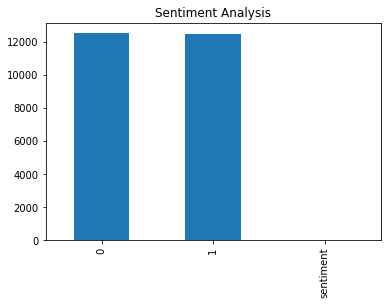

In [172]:
import matplotlib.pyplot as plt
df['sentiment'].value_counts().plot.bar()
plt.title("Sentiment Analysis")
df['sentiment'].value_counts(normalize = True)

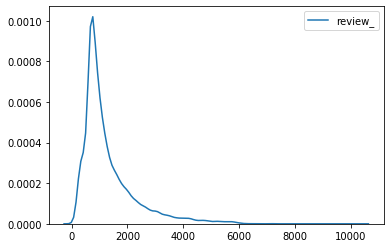

In [173]:
import seaborn as sns
df['review_'] = df['review'].astype(str).apply(len)
sns.kdeplot(df['review_'])

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25001 entries, 0 to 25000
Data columns (total 3 columns):
review       25001 non-null object
sentiment    25001 non-null object
review_      25001 non-null int64
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [0]:
from torch.utils.data import DataLoader, Dataset

加载数据并对数据预处理
1.读数据
2.切分句子
3.填充（pad）
4.转ID
5.转tensor

In [0]:
class LoadDataset(Dataset):

    def __init__(self,filename,maxlen): 

        self.df = pd.read_csv(filename,delimiter = ',')

        self.maxlen = maxlen

        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        
    def __len__(self):

        return len(self.df)

    def __getitem__(self,index):

      sentence = self.df.loc[index,'review'] 

      label = self.df.loc[index,'sentiment']

      tokens = self.tokenizer.tokenize(sentence)

      tokens = ['[CLS]'] + tokens + ['[SEP]']

      #print(tokens)
      if len(tokens) < self.maxlen:

          tokens = tokens + ['[PAD]' for _ in range(self.maxlen - len(tokens))]

      else:

          tokens = tokens[:self.maxlen -1] + ['[PAD]']

      #print(tokens)

      tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      #print(tokens_ids)

      tokens_ids_tensor = torch.tensor(tokens_ids)
      #print(tokens_ids_tensor)

      attn_mask = (tokens_ids_tensor != 0).long()

      return tokens_ids_tensor, attn_mask, label

实例化训练集和验证集

In [0]:
train_set = LoadDataset(filename = 'data/train.csv',maxlen = 64)

val_set = LoadDataset(filename = 'data/validation.csv',maxlen = 64)

把数据集按batch_size大小分成n等份个迭代

In [178]:
train_loader = DataLoader(train_set,batch_size = 32,num_workers = 5)

val_loader = DataLoader(val_set,batch_size = 32, num_workers = 5)

print(len(train_loader))
print(len(val_loader))

782
782


情感分类模型设计

In [0]:
from torch import nn

In [0]:
class SentimentClassifier(nn.Module): 

    def __init__(self,freeze_bert = True):

        super(SentimentClassifier,self).__init__()

        self.bert_layer = BertModel.from_pretrained('bert-base-uncased')

        self.dropout = nn.Dropout(0.1)

        self.classifier = nn.Linear(768,1)

    def forward(self,seq,attn_masks): 

        cont_reps,_ = self.bert_layer(seq,attention_mask = attn_masks) #把处理好的数据放入bert中以得到特征表示，大小为[32,64,768]

        cls_rep = cont_reps[:,0]   #取[CLS]也即第一个，大小为[32,768]

        logits = self.classifier(cls_rep) #把[CLS]做一个连接，大小为[32,1]

        return logits                  

In [0]:
model = SentimentClassifier()

为训练准备损失函数和优化器：
1.训练是损失函数用BCEWithLogtsLoss、优化器用Adam
2.验证是优化器也用Adam

In [0]:
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss

In [0]:
criterion = BCEWithLogitsLoss()

optimizer = Adam(model.parameters(),lr = 2e-5)

In [184]:
if torch.cuda.is_available():

    device = 'cuda'

else:
  
    device = 'cpu'

print(device)

cuda


In [0]:
from time import time

In [0]:
def logits_accuracy(logits,labels):

    probs = torch.sigmoid(logits.unsqueeze(-1))

    #print("probs shape:",probs.shape)
    preds = (probs > 0.5).long() 

    #print("preds shape:",preds.shape)
    #print("preds.squeeze shape:",preds.squeeze().shape)
    acc = (preds.squeeze() == labels).float().mean()
    
    return acc

In [0]:
def evaluate(net,criterion,val_loader,device):

    losses ,accuracies = 0,0

    net.eval()

    count = 0         #count用来计数（迭代数）用于后面对损失和准确率做平均

    for (seq,attn_masks,labels) in val_loader:

        count += 1    

        seq,attn_masks,labels = seq.to(device),attn_masks.to(device),labels.to(device)

        val_logits = net(seq,attn_masks)

        val_loss = criterion(val_logits.squeeze(-1),labels.float())

        losses += val_loss.item()   #累加所有迭代的损失
        
        accuracies += logits_accuracy(val_logits,labels)    

        return losses / count , accuracies / count

In [0]:
def train(net,criterion,optimizer,train_loader,val_loader,device,epochs = 4 ,print_every = 100):

    net.to(device)  #给模型配置GPU/CPU

    net.train()   

    print('========================START TRAINING=================================')

    for epoch in range(epochs):   

        print('=======================EPOCH :{}'.format(epoch))

        t1 = time()   #一个epoch的开始时间

        for i , (seq,attn_masks,labels) in enumerate(train_loader):  #i用于打印多少次迭代

            optimizer.zero_grad() 

            seq, attn_masks, labels = seq.to(device),attn_masks.to(device),labels.to(device)  #给数据配置GPU/CPU

            logits = net(seq,attn_masks)  #[32,1]

            loss = criterion(logits.squeeze(-1),labels.float())

            loss.backward()

            nn.utils.clip_grad_norm_(net.parameters(),1)  #防止梯度爆炸

            optimizer.step()  #反向传播后更新模型参数

            if (i+1) % print_every == 0:

                print('\n\nIteratiom:{}\nLoss:{}'.format(i+1,loss.item())) #每训练完100个迭代打印此时的损失

        t2 = time()       #一个epoch的结束时间

        print('Taken time for EPOCH:{}'.format(t2-t1))

        print('\n======================Validating=================')

        mean_val_loss, mean_val_acc = evaluate(net,criterion,val_loader,device) #每训练完一个epoch，算损失和准确率

        print('Validation Loss:{}\nValidation Accuracy:{}'.format(mean_val_loss,mean_val_acc)) 


In [189]:
train(model,criterion,optimizer,train_loader,val_loader,device,epochs = 1,print_every = 100)

========================START TRAINING=================================
=======================EPOCH :0


Iteratiom:100
Loss:0.4208635091781616


Iteratiom:200
Loss:0.6658065319061279


Iteratiom:300
Loss:0.400304913520813


Iteratiom:400
Loss:0.43304798007011414


Iteratiom:500
Loss:0.3171434998512268


Iteratiom:600
Loss:0.3901852071285248


Iteratiom:700
Loss:0.39116454124450684
Taken time for EPOCH:534.2826356887817

======================Validating=================
Validation Loss:0.3435032367706299
Validation Accuracy:0.875


存储模型参数

In [0]:
import os

In [0]:
if not os.path.isdir('./save_path'):

    os.mkdir('./save_path')

torch.save({
    
    'model_state_dict': model.state_dict(),

    'optimizer_state_dict':optimizer.state_dict()
    
},'save_path/model.pth')

保存整个网络:torch.save(net, PATH) 
保存网络中的参数, 速度快，占空间少:torch.save(net.state_dict(),PATH)
针对上面一般的保存方法，加载的方法分别是：
model_dict=torch.load(PATH)
model_dict=model.load_state_dict(torch.load(PATH))
详见https://zhuanlan.zhihu.com/p/38056115

In [0]:
 #model.state_dict().items()
 #optimizer.state_dict().items()

In [0]:
#checkpoint = torch.load('save_path/model.pth')  

In [0]:
#model.load_state_dict(checkpoint['model_state_dict'])

In [0]:
#model.load_state_dict


In [0]:
inference_file = torch.load('save_path/model.pth')

In [0]:
predictor = SentimentClassifier()

In [197]:
predictor.load_state_dict(inference_file['model_state_dict']) #模型加载训练好的参数
print(predictor)

SentimentClassifier(
  (bert_layer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [0]:
#与数据处理类一样
def preprocess(sentence, maxlen=64):

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    tokens = tokenizer.tokenize(sentence)

    tokens = ['[CLS]'] + tokens + ['[SEP]']

    if len(tokens) < maxlen:

        tokens = tokens + ['[PAD]' for _ in range(maxlen - len(tokens))]
    else:

        tokens = tokens[:maxlen-1] + ['[SEP]']
    
    tokens_ids = tokenizer.convert_tokens_to_ids(tokens)
    
    tokens_ids_tensor = torch.tensor(tokens_ids).unsqueeze(0)

    attn_mask = (tokens_ids_tensor != 0).long()

    return tokens_ids_tensor, attn_mask

做预测

In [0]:
def predict(net, iseq, masks):

    device = 'cpu'

    net.eval()

    iseq, masks = iseq.to(device), masks.to(device)

    p_logit = net(iseq, masks)    #[32,1]

    probs = torch.sigmoid(p_logit.unsqueeze(-1))  #进行非线性激活得到一个概率值  

    print(probs.size())       # [1,1,1] batch_size、sequence_length、divimension 
            
    preds = (probs > 0.5).long().squeeze(0)     #得到标签

    print(preds.size())               # [1,1]

   
    return preds, probs

In [0]:
test_tokens, test_attn = preprocess("I pretty like this beautiful dress")

In [201]:
print(test_tokens)

tensor([[ 101, 1045, 3492, 2066, 2023, 3376, 4377,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]])


In [202]:
print(test_attn)

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


In [203]:
preds, probs = predict(predictor,test_tokens,test_attn)
print(preds,probs)

torch.Size([1, 1, 1])
torch.Size([1, 1])
tensor([[1]]) tensor([[[0.8649]]], grad_fn=<SigmoidBackward>)
